# Q1

In [5]:
import numpy as np
import scipy.stats as stats

def metropolis_within_gibbs(n_samples=100, data=None, mu_0=0, tau_0=1, sigma_0=1, nu_vals=np.arange(1, 101)):
    mu = np.mean(data) 
    sigma2 = np.var(data)  
    nu = np.random.choice(nu_vals) 
    
    samples = []
    for _ in range(n_samples):
        tau_n = tau_0 + len(data) / sigma2
        mu_n = (tau_0 * mu_0 + np.sum(data) / sigma2) / tau_n
        mu = np.random.normal(mu_n, np.sqrt(1 / tau_n))
        
        sigma2_prop = np.abs(np.random.normal(np.sqrt(sigma2), 1))**2 
        log_accept_ratio = (
            -0.5 * np.sum((data - mu)**2 / sigma2_prop) 
            + 0.5 * np.sum((data - mu)**2 / sigma2) 
            - (sigma2_prop / (2 * sigma_0**2)) 
            + (sigma2 / (2 * sigma_0**2))
        )
        if np.log(np.random.uniform()) < log_accept_ratio:
            sigma2 = sigma2_prop
        
        nu_prop = np.random.choice(nu_vals)
        log_accept_ratio = (
            stats.t.logpdf(data, df=nu_prop, loc=mu, scale=np.sqrt(sigma2)).sum() 
            - stats.t.logpdf(data, df=nu, loc=mu, scale=np.sqrt(sigma2)).sum()
        )
        if np.log(np.random.uniform()) < log_accept_ratio:
            nu = nu_prop
        
        
        samples.append((mu, sigma2, nu))
    
    return np.array(samples)

data = np.random.standard_t(df=5, size=100)  
samples = metropolis_within_gibbs(n_samples=100, data=data)


# Q2

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<Figure size 1000x600 with 0 Axes>

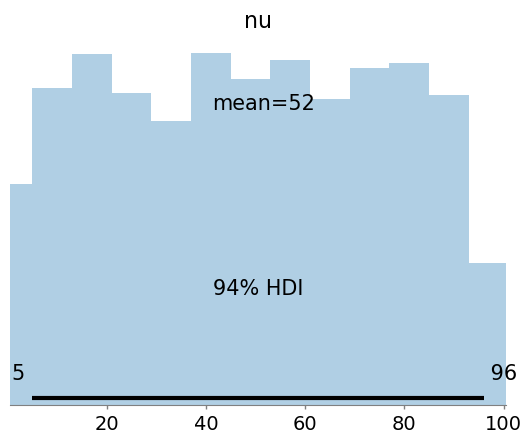

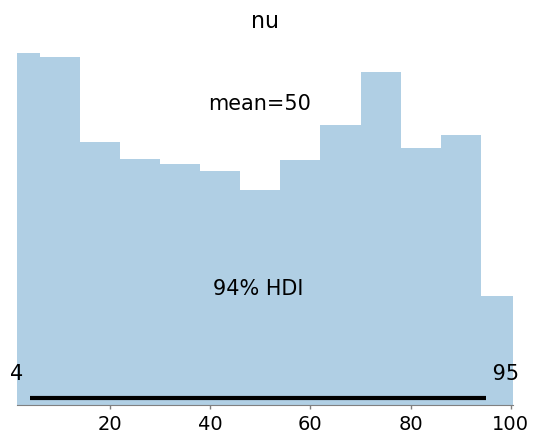

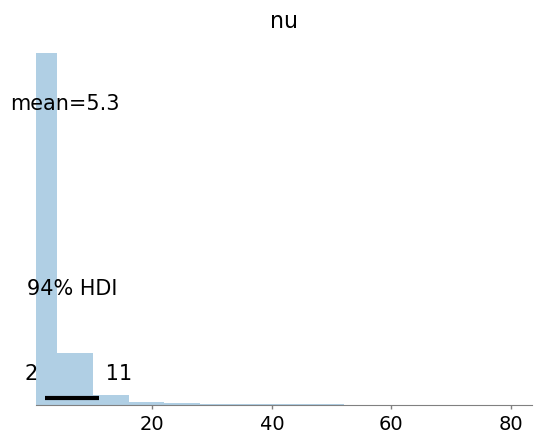

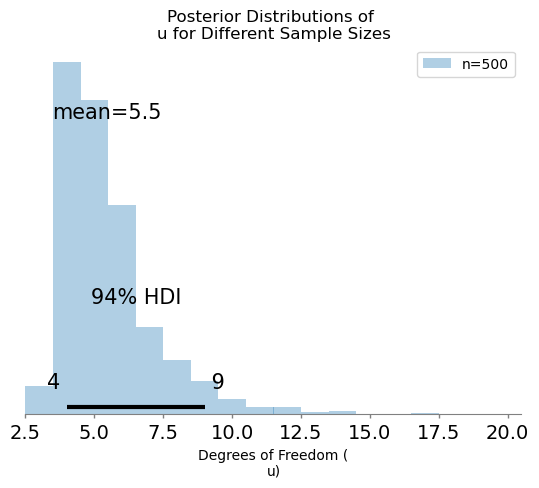

In [7]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

def run_pymc_inference(sample_size=100, true_nu=5, draws=1000, tune=1000):
    data = np.random.standard_t(df=true_nu, size=sample_size)
    
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        
        likelihood = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)
   
        trace = pm.sample(draws=draws, tune=tune, return_inferencedata=True, target_accept=0.9)
    
    return trace

def plot_nu_posterior(traces, sample_sizes):
    
    plt.figure(figsize=(10, 6))
    for trace, n in zip(traces, sample_sizes):
        az.plot_posterior(trace["posterior"].nu, label=f"n={n}")
    plt.legend()
    plt.title("Posterior Distributions of \nu for Different Sample Sizes")
    plt.xlabel("Degrees of Freedom (\nu)")
    plt.show()


sample_sizes = [10, 50, 100, 500]
traces = [run_pymc_inference(sample_size=n) for n in sample_sizes]


plot_nu_posterior(traces, sample_sizes)

If the sample size is small (e.g., n=10), the posterior distribution for ν is diffuse and imprecise, i.e., we know little about making inferences about the true degrees of freedom parameter.
As the sample size increases, the posterior will be more peaked, indicating our greater confidence in our inference about ν.
On larger sample sizes, posterior estimation of ν converges towards the real parameter values (ν=5 in our simulation).

# Q3

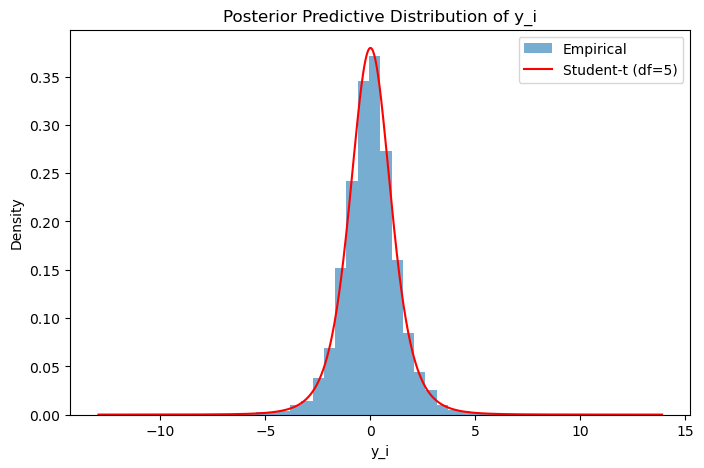

In [8]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

nu = 5 
num_samples = 10000 


tau_samples = np.random.gamma(nu / 2, 2 / nu, size=num_samples)

y_samples = np.random.normal(0, np.sqrt(1 / tau_samples))

t_dist_samples = stats.t.rvs(df=nu, loc=0, scale=1, size=num_samples)

plt.figure(figsize=(8, 5))
plt.hist(y_samples, bins=50, density=True, alpha=0.6, label="Empirical")
x_vals = np.linspace(min(y_samples), max(y_samples), 1000)
plt.plot(x_vals, stats.t.pdf(x_vals, df=nu), 'r-', label=f"Student-t (df={nu})")
plt.title("Posterior Predictive Distribution of y_i")
plt.xlabel("y_i")
plt.ylabel("Density")
plt.legend()
plt.show()
